In [154]:
import torch
import numpy as np

import scipy
import xarray as xr
import pandas as pd
import pickle as pkl

import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. fMRI pre-processing

1. we first isolate noun / verb selective vertices with $p < 0.05$ on the group level
2. from these, we extract the top 300 noun-selective and verb-selective vertices by subject

these form our ROIs

## step one: group level isolation

In [178]:
group_level = xr.open_dataset('group-level-contrast-even.nc')
num_coords = len(group_level.t_values)

In [179]:
group_level = group_level.to_pandas()
group_level = group_level.drop(group_level[group_level.p_values > 0.05].index)
group_level = group_level.dropna()

In [180]:
group_level['region'] = group_level['t_values'].apply(lambda x: 'noun' if x < 0 else 'verb')
group_level['region'].value_counts()

region
noun    6151
verb    2692
Name: count, dtype: int64

In [181]:
group_level.head()

,t_values,p_values,region
coords,,,
0,-2.358720,0.028105,noun
5,-3.736453,0.001218,noun
6,-3.695950,0.001341,noun
9,-2.739922,0.012271,noun
12,-2.803860,0.010637,noun


In [182]:
noun_coords = np.array(group_level.index[group_level['region'] == 'noun'])
verb_coords = np.array(group_level.index[group_level['region'] == 'verb'])

noun_mask = np.zeros(num_coords)
noun_mask[noun_coords] = 1

verb_mask = np.zeros(num_coords)
verb_mask[verb_coords] = 1

## step two: individual level extraction

In [183]:
indiv = xr.open_dataset('individual-level-contrast-even.nc')

In [184]:
# shape (num_participants, num_coords)
noun_values = np.array(indiv.t_values) * noun_mask
verb_values = np.array(indiv.t_values) * verb_mask

In [185]:
# make it (22, 576, 300) instead of (22, 300) i.e. by-trial
# 1200 for nouns? and 300 for verbs
noun_rois = np.argsort(noun_values, axis=1)[:, :600]
verb_rois = np.argsort(verb_values, axis=1)[:, -600:]

In [186]:
noun_mask = np.zeros((22, num_coords))
noun_mask[np.arange(22)[:, None], noun_rois] = 1

verb_mask = np.zeros((22, num_coords))
verb_mask[np.arange(22)[:, None], verb_rois] = 1

In [187]:
with open('noun_mask_fmri.pkl', 'wb') as f:
    pkl.dump(noun_mask, f)

with open('verb_mask_fmri.pkl', 'wb') as f:
    pkl.dump(verb_mask, f)

# 2. model pre-processing

we apply a similar procedure for ROI identification in the model, computing the top $N$ noun / verb selective units (where $N$ is a hyperparameter)

In [198]:
N = 600 # int(0.1 * (24 * 784))

# negative = noun selective, positive = verb selective
with open('../data/contrasts/5-5-2.5-48-mean-0/elli-noun_verb.pkl', 'rb') as f:
    t_map = -pkl.load(f)

In [199]:
flattened_t_map = t_map.flatten()
noun_units = np.argsort(flattened_t_map)[:N]
verb_units = np.argsort(flattened_t_map)[-N:]

In [200]:
noun_mask = np.zeros(len(flattened_t_map))
noun_mask[noun_units] = 1
noun_mask = noun_mask.reshape(24, 784)

verb_mask = np.zeros(len(flattened_t_map))
verb_mask[verb_units] = 1
verb_mask = verb_mask.reshape(24, 784)

In [201]:
with open('noun_mask_model.pkl', 'wb') as f:
    pkl.dump(noun_mask, f)

with open('verb_mask_model.pkl', 'wb') as f:
    pkl.dump(verb_mask, f)

# 3. linear fits

we fit a GLM:

$$
\text{fmri\_t\_values} \sim \beta_0 + \beta_1 \cdot \text{model\_activations} + \epsilon
$$

where we restrict to the ROIs determined above. we enforce a one-to-one mapping of model units to fMRI vertices

In [202]:
noun_mask_fmri = np.load('noun_mask_fmri.pkl', allow_pickle=True)
verb_mask_fmri = np.load('verb_mask_fmri.pkl', allow_pickle=True)
noun_mask_model = np.load('noun_mask_model.pkl', allow_pickle=True)
verb_mask_model = np.load('verb_mask_model.pkl', allow_pickle=True)

In [203]:
with open('../data/responses/5-5-2.5-48-mean-0/elli.pkl', 'rb') as f:
    elli = pkl.load(f)

In [204]:
all_conditions = sorted(['bird_noun', 'hand_verb', 'light_verb', 'mammal_noun', 'manmade_noun', 'mouth_verb', 'natural_noun', 'sound_verb'])

activations = {}

activations['noun'] = np.concatenate([elli[key] for key in all_conditions if key[-4:] == 'noun'], axis=0).mean(axis = 0)
activations['verb'] = np.concatenate([elli[key] for key in all_conditions if key[-4:] == 'verb'], axis=0).mean(axis = 0)

In [205]:
def extract(arr, mask):
    return arr.flatten()[mask.flatten() == 1]

activations['noun'] = extract(activations['noun'], noun_mask_model)
activations['verb'] = extract(activations['verb'], verb_mask_model)

In [206]:
indiv = xr.open_dataset('individual-level-contrast-even.nc')

In [207]:
t_values = {}

t_values['noun'] = np.array(indiv.t_values)[noun_mask_fmri.astype(bool)].reshape(22, 600)
t_values['verb'] = np.array(indiv.t_values)[verb_mask_fmri.astype(bool)].reshape(22, 600)

In [220]:
x = activations['noun']
# x = sm.add_constant(x)

y = t_values['noun'][1]

model = sm.GLM(y, x)
results = model.fit()

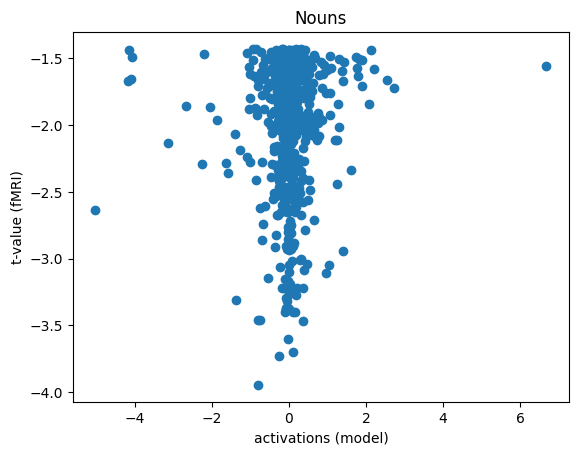

In [225]:
plt.scatter(x, y)
plt.xlabel("activations (model)")
plt.ylabel("t-value (fMRI)")
plt.title('Nouns')
plt.show()

In [228]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  600
Model:                            GLM   Df Residuals:                      599
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          4.1993
Method:                          IRLS   Log-Likelihood:                -1281.3
Date:                Thu, 29 Aug 2024   Deviance:                       2515.4
Time:                        20:02:04   Pearson chi2:                 2.52e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             -1.556
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0001      0.115     -0.001      0.999      -0.225       0.224
==============================================================================
"""